# Standard RB Demo

This is a very basic implemention of a standard RB experiment

In [1]:
import numpy as np
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

## Running 1-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 26304afe-36d9-4ce9-bb5b-25aa7fe34cd5
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4726749518248839 ± 0.008758137322890547
- alpha: 0.9923220730003991 ± 0.00037374286420385186
- b: 0.514181374459293 ± 0.008431363232072933
- analysis_type: RBAnalysis
- reduced_chisq: 0.17036018812675835
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.003838963499800452
- EPC_err: 0.00018831731872787915
- EPG: {0: {'rz': 0.0, 'sx': 0.0004266320228739593, 'x': 0.0004266320228739593}}
- success: True


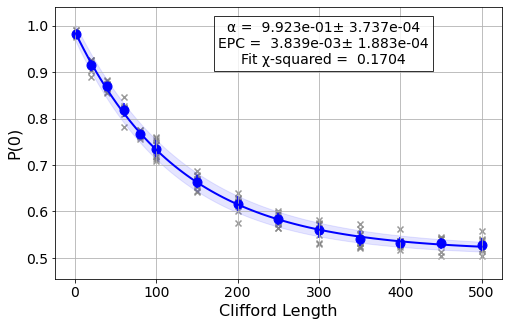

In [2]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
exp1 = rb.StandardRB([0], lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

## Running 2-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 94052ed1-0192-465b-9d15-5f4df998df93
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.7046380798602088 ± 0.024344344511788435
- alpha: 0.9572345778290758 ± 0.0024768093781139307
- b: 0.2665002377453535 ± 0.008195380705494262
- analysis_type: RBAnalysis
- reduced_chisq: 0.08536408529318697
- dof: 7
- xrange: [1.0, 200.0]
- EPC: 0.03207406662819312
- EPC_err: 0.001940597505157344
- EPG: {(0, 1): {'cx': 0.019363110733580966}}
- success: True


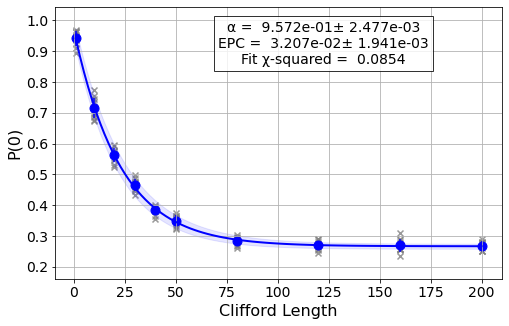

In [3]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an RB experiment on qubits 0, 1
exp2 = rb.StandardRB([0, 1], lengths, num_samples=num_samples, seed=seed)
expdata2 = exp2.run(backend)

# View result data
print(expdata2)

# Running 1-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: 63608ced-6532-4552-b7b4-3e6797e1b8b5
Status: DONE
Circuits: 280
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4759430735281106 ± 0.006980475784769323
- alpha: 0.9927018471479893 ± 0.0003075310886997852
- alpha_c: 0.9992237130414766 ± 0.00033880549133499403
- b: 0.5091052914189443 ± 0.006889225881330329
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.11150347773019198
- dof: 24
- xrange: [1.0, 500.0]
- EPC: 0.00038814347926169335
- EPC_err: 0.00016940274566749702
- EPC_systematic_err: 0.006910009372749049
- EPC_systematic_bounds: [0, 0.007298152852010742]
- success: True


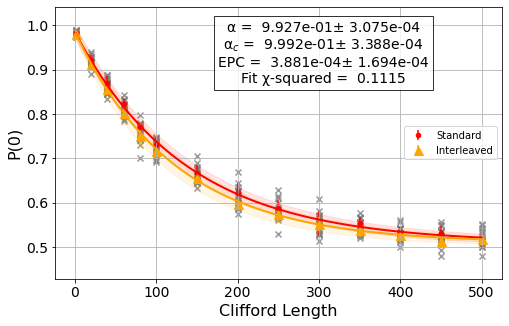

In [4]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
int_exp1 = rb.InterleavedRB(circuits.XGate(), [0], lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)

# View result data
print(int_expdata1)

# Running 2-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: 16f38a8b-9bc0-4bb2-89b4-8b7e8d6cbb54
Status: DONE
Circuits: 200
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.6945056540169231 ± 0.01859291084975834
- alpha: 0.9535642387987325 ± 0.002880295623408922
- alpha_c: 0.9844958529592424 ± 0.004409076803687636
- b: 0.2636474658497583 ± 0.004352001654548783
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.16681353065792917
- dof: 16
- xrange: [1.0, 200.0]
- EPC: 0.011628110280568232
- EPC_err: 0.0033068076027657272
- EPC_systematic_err: 0.05802553152133297
- EPC_systematic_bounds: [0, 0.0696536418019012]
- success: True


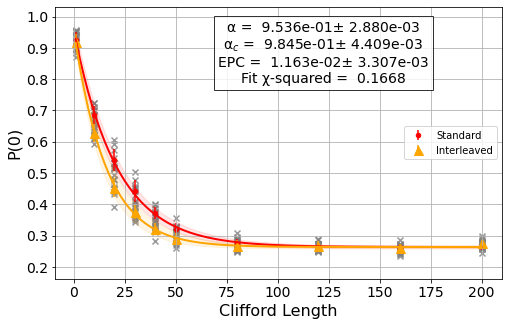

In [5]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an Interleaved RB experiment on qubits 4, 6
int_exp2 = rb.InterleavedRB(circuits.CXGate(), [4,6], lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

# View result data
print(int_expdata2)

## Running parallel RB experiments

In [ ]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

exps = [rb.StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in range(5)]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
print(par_expdata)

#### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [ ]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')